In [1]:
%%capture
!pip install einops pytorch_lightning diffusers==0.12.1 kornia librosa accelerate

In [2]:
import torch
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/Users/aleksander/Documents/Skole/Masteroppgave/DiffusionFastForward/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating datasets


torch.Size([1, 256, 256])


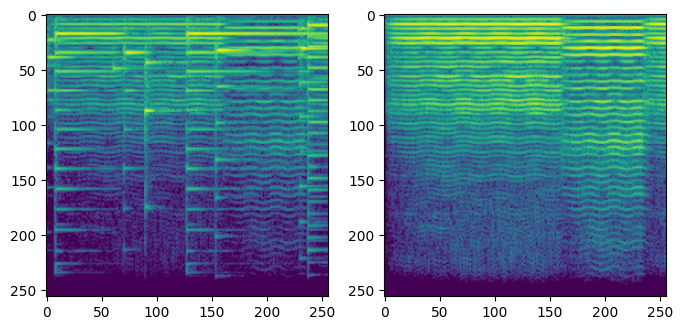

In [3]:
from dataset import SpectrogramDataset

train_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/ins3',
                            condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/mix',
                            return_pair=True,
                            out_channels=1
                     )


valid_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/ins3',
                          condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/mix',
                          return_pair=True,
                          out_channels=1
                     )

test_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/ins3',
                           condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/mix',
                           return_pair=True,
                           out_channels=1
                     )

img1,img2=train_ds[0]
print(img1.shape)

plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img2.permute(1,2,0))

### Model setup

In [4]:
model=PixelDiffusionConditional(train_ds,
                                valid_dataset=valid_ds,
                                lr=1e-5,
                                batch_size=2,
                                num_timesteps=100)

Is Time embed used ?  True


### Training

In [5]:
trainer = pl.Trainer(
    default_root_dir="trained_models/diffusion/",
    max_epochs=400,
    callbacks=[EMA(0.9999)],
    accelerator='auto'
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model)


  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | model | DenoisingDiffusionConditionalProcess | 56.6 M
---------------------------------------------------------------
56.6 M    Trainable params
0         Non-trainable params
56.6 M    Total params
226.457   Total estimated model params size (MB)


Epoch 0:   2%|▏         | 5/250 [00:56<45:56, 11.25s/it, v_num=0, train_loss=0.996]  

### Load checkpoint

In [ ]:
model = PixelDiffusionConditional.load_from_checkpoint('trained_models/diffusion/lightning_logs/version_5/checkpoints/epoch=92-step=11625.ckpt', train_dataset=train_ds)
model.to(device)

### Create Sample

In [9]:
input,output=test_ds[0]
batch_input=torch.stack(1*[input],0)

out=model(batch_input, verbose=True)

diffusion sampling: 100%|██████████| 100/100 [03:21<00:00,  2.02s/it]


(-0.5, 255.5, 255.5, -0.5)

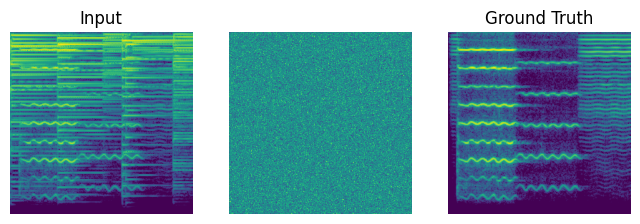

In [10]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')

In [37]:
phase = test_ds.get_phase(0)

name = test_ds.files[0]
test_ds.save_audio(out[0], phase, name = name)

[-5.9252296e-05 -1.0775418e-04 -8.1048704e-05 ...  2.1947753e-02
  2.7189558e-02  2.2157816e-02]
[ 0.17264074 -0.15296061  0.25212672 ... -0.18243688 -0.73756033
 -0.2276027 ]
